In [1]:
import andi
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras import losses, metrics

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import LSTM

from keras.layers import Dropout
from keras.layers import Bidirectional
from keras.models import load_model
import os
AD = andi.andi_datasets()


Using TensorFlow backend.
C:\Users\Aykut\Miniconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Aykut\Miniconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Aykut\Miniconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Aykut\Miniconda3\lib\site-packages\tensorflow\python\framework\dtype

In [2]:
#FUNCTION TO TURN SPLIT DATA IN NORMALIZED SUB-TRAJECTORIES.
#Possible to choose data corresponding to a certain interval of h
#USING TIMES TOO Otpion to normalize!!
#Should find a more elegant way of using the hmin and hmax, now i have to express it anyway
def data_split(data_tot,meas_times,labels,start_row,num_row,traj_len,
               n_in,n_samples,hmin=0.,hmax=1,limith=False,normalization=True,p_p=1):
    '''
    returns data_tot: collection of recorded trajectories and associated time stamps,
    split into normalized sub-trajectories. It also returns the associated labels, and
    separately the time stamps and trajectories.
    PARAMETERS EXPLANATION:
    meas_times: times at which the position was recorded,
    labels: the true exponent corresponding with which the trajectory was generated
    start_row: exclude recorded trajectories with index i<start_row
    num_row: number of recorde trajectories to use (NB the actual number
    will be <total number-start_row) 
    traj_len: length of the trajectory segments to output
    n_in: starting data point from the recorded data
    n_samples: number of the trajectory segments to take from each recorded trajectory
    h_min: use only trajectories genearted with h>h_min
    h_max: use only trajectories genearted with h<h_max
    p_p: factor introduced to roughly normalize the time steps so that the total trajectory
    duration is close to 1'''
    j=0



    tr=data_tot[start_row:num_row+start_row]
    sel_times=meas_times[start_row:num_row+start_row]
    tar=labels[start_row:num_row+start_row]

    if(limith==True):
        
        tr=tr[np.where((tar<=hmax) & (tar >=hmin))]
        sel_times=sel_times[np.where((tar<=hmax) & (tar >=hmin))]
        tar=tar[((tar<=hmax) & (tar >=hmin))]

    if(n_samples>1):
        
        gap=int((data_tot.shape[1]-n_in-traj_len)/(n_samples-1))
    else:
        gap=0    
    print("n initial=",n_in,"gap=",gap)
    if(gap<traj_len):
        print("warning!! Overlapping trajectories. gap=",
              gap,"trajectory length=",traj_len,"final_point=",
              (n_samples-1)*gap+n_in+traj_len,"data length",data_tot.shape[1])

    if(normalization==True):
        trj=tr[:,n_in+gap*j:n_in+gap*j+traj_len]
        test_data_new=(trj-(np.tile(np.transpose([np.mean(trj,axis=1)]),
                                    (1,traj_len))))/(np.tile(np.transpose([np.std(trj,axis=1)]),
                                                             (1,traj_len)))
        test_times=np.cumsum(np.insert(np.diff(sel_times[:,n_in+gap*j:n_in+gap*j+traj_len])
                                       ,0,0, axis=1),axis=1)
#train_data_new=(data_tot[start_row:30000,:traj_len]-(np.tile(np.transpose([np.mean(data_tot[start_row:30000,:traj_len],axis=1)]),(1,traj_len))))/(np.tile(np.transpose([np.std(data_tot[start_row:30000,:traj_len],axis=1)]),(1,traj_len)))
        test_labels_large=tar
#test_labels=labels[start_row:num_row+start_row]
        #print(test_data_new.shape)
        #print("trj=",trj.shape)
        #print("sart=",n_in+gap*j,"end=",n_in+gap*j+traj_len)
        for j in range(1,n_samples):
            trj=tr[:,n_in+gap*j:n_in+gap*j+traj_len]
            #print("sart=",n_in+gap*j,"end=",n_in+gap*j+traj_len)
            #print(trj.shape)
            test_data_new=np.concatenate((test_data_new,(trj-(np.tile(np.transpose([np.mean(trj,axis=1)]),(1,traj_len))))/(np.tile(np.transpose([np.std(trj,axis=1)]),(1,traj_len)))),axis=0)
    #test_data_new=np.concatenate((test_data_new,(data_tot2[:,n_in+gap*j:n_in+gap*j+traj_len]-np.mean(data_tot2[:,n_in+gap*j:n_in+gap*j+traj_len]))/np.std(data_tot2[:,n_in+gap*j:n_in+gap*j+traj_len])),axis=0)
            test_labels_large=np.append(test_labels_large,tar)
            test_times=np.concatenate((test_times,np.cumsum(np.insert(np.diff(sel_times[:,n_in+gap*j:n_in+gap*j+traj_len]),0,0, axis=1),axis=1)),axis=0)
    #test_labels=np.append(test_labels,many_label2)  
    else:
        test_data_new=tr[:,n_in+gap*j:n_in+gap*j+traj_len]
        test_times=np.cumsum(np.insert(np.diff(sel_times[:,n_in+gap*j:n_in+gap*j+traj_len]),
                                       0,0, axis=1),axis=1)
#train_data_new=(data_tot[start_row:30000,:traj_len]-(np.tile(np.transpose([np.mean(data_tot[start_row:30000,:traj_len],axis=1)]),(1,traj_len))))/(np.tile(np.transpose([np.std(data_tot[start_row:30000,:traj_len],axis=1)]),(1,traj_len)))
        test_labels_large=tar
#test_labels=labels[start_row:num_row+start_row]
        for j in range(1,n_samples):
            test_data_new=np.concatenate((test_data_new,tr[:,n_in+gap*j:n_in+gap*j+traj_len]),
                                         axis=0)
    #test_data_new=np.concatenate((test_data_new,(data_tot2[:,n_in+gap*j:n_in+gap*j+traj_len]-np.mean(data_tot2[:,n_in+gap*j:n_in+gap*j+traj_len]))/np.std(data_tot2[:,n_in+gap*j:n_in+gap*j+traj_len])),axis=0)
            test_labels_large=np.append(test_labels_large,tar)
            test_times=np.concatenate((test_times,np.cumsum(
                np.insert(np.diff(sel_times[:,n_in+gap*j:n_in+gap*j+traj_len]),0,0, axis=1),
                axis=1)),axis=0)
    #test_labels=np.append(test_labels,many_label2) 
        


#normalization of time stamps, potentially dangerous!!!!!!!
    test_times=test_times*p_p/traj_len
    
#RESHAPING
    test_set=np.transpose(np.array((np.transpose(test_data_new),np.transpose(test_times))))  
    return test_set, test_labels_large, test_data_new,test_times
   

In [ ]:
#LTSM network for learning  the Hurst exponet H, Normalized trajectories!!!

#Building the network
model_norm_long = Sequential()
#first layer: LSTM of dimension 64
model_norm_long.add(LSTM(250,
                return_sequences=True,
                dropout=0,
                recurrent_dropout=0.2,
                input_shape=(None, 25)
                ))

#second layer: LSTM of dimension 16

model_norm_long.add(LSTM(50,
                dropout=0,
                recurrent_dropout=0.2))

#Last layer, fully connected
model_norm_long.add(Dense(1))
model_norm_long.compile(optimizer='adam',
                loss='mse', 
                metrics=['mae'])

#Printing a summary of the built network
model_norm_long.summary()

#Training the network first with minibatches of size 32 for 10 epochs, 
#then with minibatches of size 128
    


In [52]:
from keras.models import load_model
model_norm_long = load_model('task1_1d_225.h5')




In [48]:
i = 425
N = 10000
X1, Y1, X2, Y2, X3, Y3 = AD.andi_dataset(N = N, tasks = 1, dimensions = 1,
                                             min_T = i, max_T = i+1, load_dataset=True, path_datasets=str(i)+'master2')


Creating a dataset for task(s) 1 and dimension(s) 1.


100000

In [53]:
test_tim_step=np.arange(i)
show_time_coll=np.tile(test_tim_step,(len(X1[0]),1))
N = 10000
data_show,label_show,traj_show,times_show=data_split(np.asarray(X1[0]),
                                                                     show_time_coll,labels=np.asarray(Y1[0]),
                                                                     start_row=0,num_row=N,traj_len=225,n_in=0,
                                                                     n_samples=2,p_p=1,hmin=0.25,hmax=0.75,
                                                                     limith=False,normalization=True)



n initial= 0 gap= 200
warning!! Overlapping trajectories. gap= 200 trajectory length= 225 final_point= 425 data length 425


In [56]:
label_show[:10]

array([0.05, 1.4 , 1.45, 1.4 , 1.25, 1.35, 0.25, 1.55, 1.9 , 0.1 ])

In [58]:
i = 225
label_predicted = model_norm_long.predict(traj_show.reshape(len(traj_show),int(i/5),5))

label_predicted.shape
traj_show.shape


(20000, 225)

0.19652746482029557
(10000, 1)


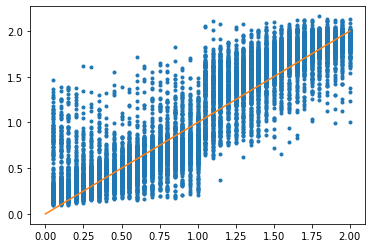

In [32]:
import matplotlib.pyplot as plt
plt.plot(Y1[0][:10000], label_predicted,'.')
plt.plot([0,2],[0,2])


print(np.mean(np.abs((Y1[0][:10000])-label_predicted.flatten())))
print(label_predicted.shape)

0.17719584421887993
(10000, 1)
Network: 425, Traj_length: 425


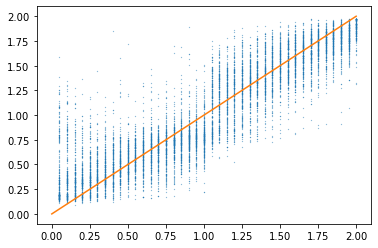

In [51]:
import matplotlib.pyplot as plt
plt.plot(Y1[0][:10000], label_predicted,'.',markersize=0.4)
plt.plot([0,2],[0,2])


print(np.mean(np.abs((Y1[0][:10000])-label_predicted.flatten())))
print(label_predicted.shape)
print('Network: 425, Traj_length: 425')

In [63]:
print(label_show[:10])
print(label_show[10000:10010])

[0.05 1.4  1.45 1.4  1.25 1.35 0.25 1.55 1.9  0.1 ]
[0.05 1.4  1.45 1.4  1.25 1.35 0.25 1.55 1.9  0.1 ]


0.21230273198485375


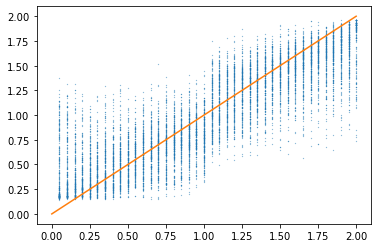

In [60]:
label_p = (label_predicted[:10000] + label_predicted[10000:])/2


print(np.mean(np.abs((Y1[0][:10000])-label_p.flatten())))
plt.plot(Y1[0][:10000], label_p,'.',markersize=0.4)
plt.plot([0,2],[0,2])

0.2090661813223362
(10000, 1)


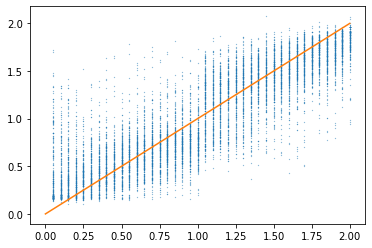

In [46]:
import matplotlib.pyplot as plt
plt.plot(Y1[0][:10000], label_predicted,'.',markersize=0.4)
plt.plot([0,2],[0,2])


print(np.mean(np.abs((Y1[0][:10000])-label_predicted.flatten())))
print(label_predicted.shape)

In [ ]:
i = 825
#X1, Y1, X2, Y2, X3, Y3 = AD.andi_dataset(N = 10000, tasks = 1, dimensions = 1, min_T = i, max_T = i+1)
test_tim_step=np.arange(i)
show_time_coll=np.tile(test_tim_step,(len(X1[0]),1))
for batch_size in [512, 2048]:
    #N = int(100000 / 4 * (np.log2(batch_size)-3)/2)
    N = 100000
    X1, Y1, X2, Y2, X3, Y3 = AD.andi_dataset(N = N, tasks = 1, dimensions = 1,
                                             min_T = i, max_T = i+1, load_dataset=True, path_datasets=str(i)+'master2')
    
    
    data_show,label_show,traj_show,times_show=data_split(np.asarray(X1[0]),
                                                                     show_time_coll,labels=np.asarray(Y1[0]),
                                                                     start_row=0,num_row=N,traj_len=i,n_in=0,
                                                                     n_samples=1,p_p=1,hmin=0.25,hmax=0.75,
                                                                     limith=False,normalization=True)
    #traj_show = np.array(X1[0])
    #label_show = np.array(Y1[0])
    
    for repeatings in range(20):
        print(['Training step =' + str(repeatings)])
        history_norm_long = model_norm_long.fit(traj_show.reshape(len(traj_show),int(i/25),25)[:-66667], 
                                label_show[:-66667], 
                                epochs=1, 
                                batch_size=batch_size,
                                shuffle=True,
                                validation_split=0.1)
        history_norm_long = model_norm_long.fit(traj_show.reshape(len(traj_show),int(i/25),25)[33333:-33334], 
                                label_show[33333:-33334], 
                                epochs=1, 
                                batch_size=batch_size,
                                shuffle=True,
                                validation_split=0.1)
        history_norm_long = model_norm_long.fit(traj_show.reshape(len(traj_show),int(i/25),25)[66666:], 
                                label_show[66666:], 
                                epochs=1, 
                                batch_size=batch_size,
                                shuffle=True,
                                validation_split=0.1)

In [ ]:
model_norm_long.save('task1_1d_825.h5')

In [ ]:
label_show.shape

In [ ]:
cl=25+100*np.arange(10)
for i in cl:
    X1, Y1, X2, Y2, X3, Y3 = AD.andi_dataset(N = 100000, tasks = 1, dimensions = 1, min_T = i, max_T = i+1, save_dataset=True, path_datasets=str(i)+'master1')
    print('Finished with ' + str(i))

In [ ]:
for i in cl:
    X1, Y1, X2, Y2, X3, Y3 = AD.andi_dataset(N = 100000, tasks = 1, dimensions = 1, min_T = i, max_T = i+1, save_dataset=True, path_datasets=str(i)+'master2')
    print('Finished with ' + str(i))

In [ ]:
for i in cl:
    X1, Y1, X2, Y2, X3, Y3 = AD.andi_dataset(N = 100000, tasks = 1, dimensions = 1, min_T = i, max_T = i+1, save_dataset=True, path_datasets=str(i)+'master3')
    print('Finished with ' + str(i))

In [ ]:
len(X1[0][:-66667])

In [ ]:
len(X1[0][66666:])

In [ ]:
label_show.shape